In [102]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
from utils import *
from timeit import default_timer
from pytorch_wavelets import DWT, IDWT # (or import DWT, IDWT)

torch.manual_seed(0)
np.random.seed(0)
from wavelet_convolution import WaveConv2dCwt


In [103]:
# %%    
""" The forward operation """
class WNO2d(nn.Module):
    def __init__(self, width, level, layers, size, wavelet, in_channel, grid_range, padding):
        super(WNO2d, self).__init__()

        """
        The WNO network. It contains l-layers of the Wavelet integral layer.
        1. Lift the input using v(x) = self.fc0 .
        2. l-layers of the integral operators v(j+1)(x,y) = g(K.v + W.v)(x,y).
            --> W is defined by self.w; K is defined by self.conv.
        3. Project the output of last layer using self.fc1 and self.fc2.
        
        Input : (T_in+1)-channel tensor, solution at t0-t_T and location (u(x,y,t0),...u(x,y,t_T), x,y)
              : shape: (batchsize * x=width * x=height * c=T_in+1)
        Output: Solution of a later timestep (u(x, T_in+1))
              : shape: (batchsize * x=width * x=height * c=1)
              
        Input parameters:
        -----------------
        width : scalar, lifting dimension of input
        level : scalar, number of wavelet decomposition
        layers: scalar, number of wavelet kernel integral blocks
        size  : list with 2 elements (for 2D), image size
        wavelet: string, wavelet filter
        in_channel: scalar, channels in input including grid
        grid_range: list with 2 elements (for 2D), right supports of 2D domain
        padding   : scalar, size of zero padding
        """

        self.level = level
        self.width = width
        self.layers = layers
        self.size = size
        self.wavelet1 = wavelet[0]
        self.wavelet2 = wavelet[1]
        self.in_channel = in_channel
        self.grid_range = grid_range 
        self.padding = padding
        
        self.conv = nn.ModuleList()
        self.w = nn.ModuleList()
        
        self.fc0 = nn.Linear(self.in_channel, self.width) # input channel is 12: (u(x,y,t0),...u(x,y,t_T), x, y)
        for i in range( self.layers ):
            self.conv.append( WaveConv2dCwt(self.width, self.width, self.level, self.size, self.wavelet1,self.wavelet2))##**LEARN THIS*/
            self.w.append( nn.Conv2d(self.width, self.width, 1) )
        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)    
        x = self.fc0(x)                      # Shape: Batch * x * y * Channel
        x = x.permute(0, 3, 1, 2)            # Shape: Batch * Channel * x * y
        if self.padding != 0:
            x = F.pad(x, [0,self.padding, 0,self.padding]) 
        
        for index, (convl, wl) in enumerate( zip(self.conv, self.w) ):
            x = convl(x) + wl(x) 
            if index != self.layers - 1:     # Final layer has no activation    
                x = F.gelu(x)                # Shape: Batch * Channel * x * y
                
        if self.padding != 0:
            x = x[..., :-self.padding, :-self.padding]     
        x = x.permute(0, 2, 3, 1)            # Shape: Batch * x * y * Channel
        x = F.gelu( self.fc1(x) )            # Shape: Batch * x * y * Channel
        x = self.fc2(x)                      # Shape: Batch * x * y * Channel
        return x
    
    def get_grid(self, shape, device):
        # The grid of the solution
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, self.grid_range[0], size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, self.grid_range[1], size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)


In [104]:
import os
import torch
import torchvision.transforms as transforms
from PIL import Image
import torchvision.io
from torch.utils.data import Dataset,DataLoader
from scipy import io as sio


In [97]:
class custom_dataset(object):
    def __init__ (self,input_folder,output_folder,filename, transform=None):
        self.input_folder = input_folder
        self.output_folder = output_folder
        self.transform = transform
        
        self.input_images,self.output_images=self._get_file_tensor()
        self.file_name=filename
        sio.savemat(self.file_name, mdict={'x_data':self.input_images, 'y_data':self.output_images})
        
    def _get_file_tensor(self):
        
        dir_list = os.listdir(self.output_folder)
        y_arr=[]
        x_tensor=[]
        
        for j in range(len(dir_list)):
            img_tensor=[]
            x_img_arr=[]
            i=0
            y_img=os.path.join(self.output_folder,dir_list[j])
            
            y_arr.append(plt.imread(y_img))
            while(i<8):
                x_name=''+dir_list[j][1:len(dir_list[j])-4]+'_'+str(i+1)+'.png'
                x_img=os.path.join(self.input_folder,x_name)
                    # img_n=plt.imread(img)
                    
                x_img_arr.append(plt.imread(x_img))
                i+=1
            
            
            img_tensor=np.stack((x_img_arr),axis=-1)
            x_tensor.append(img_tensor)
            
        x_tensor=np.stack(x_tensor)
        y_arr=np.stack(y_arr)
        
        return x_tensor,y_arr

    def get_mat(self):
        return self.file_name
    
input_folder="C:\\S.C. research\\WNO\\New folder\\mywork\\Dynamic_Dataset\\Dynamic_Dataset"
output_folder=""

obj=custom_dataset(input_folder,output_folder,"Topology_input_file_dynamic_load.mat")

        

In [98]:
reader=MatReader("Topology_input_file_1.mat")    
print(reader.data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'x_data', 'y_data'])


In [105]:
reader2=MatReader("C:\\S.C. research\\WNO\\New folder\\mywork\\INN-TO\\DataSet\\X_y_8568_all_iter_new.hdf5")
print(reader2.data.keys())


<KeysViewHDF5 ['x_test_all', 'x_train_all', 'y_test_all', 'y_train_all']>


In [7]:
# #!/usr/bin/env python3
# # -*- coding: utf-8 -*-
# """
# Created on Tue Mar  5 23:04:02 2024

# @author: user
# """

# import os
# this_dir = "C:\\S.C. research\\WNO\\New folder"

# import numpy as np
# from scipy import io as sio
# import matplotlib.pyplot as plt

# # %%
# # Load the training set:
# y_data_path = this_dir + "\\train_in_new_64\\"
# y_data_image_list = os.listdir( y_data_path )
# y_data_len = len( y_data_image_list )
# y_data_image_name = [os.path.splitext( y_data_image_list[i] )[0] for i in range(y_data_len)]

# # %%
# # Load the testing images:
# x_data_path = this_dir + "\\y_train_64_iter_1to10\\"
# x_data_image_list = os.listdir( x_data_path )
# x_data_len = len( x_data_image_list )
# x_data_image_name = [os.path.splitext( x_data_image_list[i] )[0] for i in range(x_data_len)]

# # %%
# x_data = []
# y_data = []

# for sample in range( y_data_len ):
#     if sample % 100 == 0:
#         print('sample-{}'.format(sample))
    
#     y_data.append( plt.imread( y_data_path + y_data_image_list[sample] ) )
    
#     x_sample_data = []
#     for i in range(10):
#         x_imagename = 'y' + y_data_image_name[sample][1:] + '_' + str(i+1) + '.png'
#         x_sample_data.append( plt.imread( x_data_path + x_imagename ) )
#     x_sample_data = np.stack(( x_sample_data ), axis=-1)
#     x_data.append( x_sample_data )

# y_data = np.stack( y_data )
# x_data = np.stack( x_data )

# sio.savemat('Topology_data.mat', mdict={'x_data':x_data, 'y_data':y_data})

# # %%
# fig1, ax = plt.subplots(nrows=6, ncols=11, figsize=(14,10), dpi=100)

# indices = np.random.permutation( len(x_data) )[:6] 
# for i in range( len(indices) ):
#     for j in range( 11 ):
#         if j == 10:
#             ax[i, j].imshow( y_data[indices[i], :, :] )
#             ax[i, j].set_title('Final', color='m')
#         else:
#             ax[i, j].imshow( x_data[indices[i], :, :, j] )
#             ax[i, j].set_title('Step-{}'.format(j), color='red')
#             if j == 0:
#                 ax[i, j].set_ylabel('Sample-{}'.format(indices[i]), color='blue')


In [100]:
tr_x_data=reader2.read_field('y_train_all')
tr_y_data=reader2.read_field('x_train_all')
ts_x_data=reader2.read_field('y_test_all')
ts_y_data=reader2.read_field('x_test_all')

data_in=torch.cat((torch.permute(tr_x_data,(3,0,1,2)),torch.permute(ts_x_data,(3,0,1,2))),0)[...,1::2] # data slicing needed

data_out=torch.cat((torch.permute(tr_y_data,(2,0,1)),torch.permute(ts_y_data,(2,0,1))),0)
# print(train_out.shape)
# print(train_in.shape)
# test_in = torch.permute(ts_x_data,(3,0,1,2))[8046-tr_x_data.shape[3]:]# Data slicling needed
# test_out=torch.permute(ts_y_data,(2,0,1))[8046-tr_y_data.shape[2]:]
# print(test_in.shape)
# print(test_out.shape)
print(data_in.shape)
print(data_out.shape)



torch.Size([8568, 64, 64, 5])
torch.Size([8568, 64, 64])


In [106]:
reader7=MatReader("C:\\S.C. research\\WNO\\New folder\\mywork\\INN-TO\\DataSet\\X_y_8580_all_iter_new.hdf5")
reader7.data.keys()

tr_x_data=reader7.read_field('y_train_all')
tr_y_data=reader7.read_field('x_train_all')
ts_x_data=reader7.read_field('y_test_all')
ts_y_data=reader7.read_field('x_test_all')

# train_in=torch.cat((torch.permute(tr_x_data,(3,0,1,2)),torch.permute(ts_x_data,(3,0,1,2))[:8060-tr_x_data.shape[3]]),0)
# train_out=torch.cat((torch.permute(tr_y_data,(2,0,1)),torch.permute(ts_y_data,(2,0,1))[:8060-tr_y_data.shape[2]]),0)
# print(train_out.shape)
# print(train_in.shape)
# test_in = torch.permute(ts_x_data,(3,0,1,2))[8060-tr_x_data.shape[3]:]
# test_out=torch.permute(ts_y_data,(2,0,1))[8060-tr_y_data.shape[2]:]
# print(test_in.shape)
# print(test_out.shape)
data_in=torch.cat((torch.permute(tr_x_data,(3,0,1,2)),torch.permute(ts_x_data,(3,0,1,2))),0)[...,1::2] # data slicing needed

data_out=torch.cat((torch.permute(tr_y_data,(2,0,1)),torch.permute(ts_y_data,(2,0,1))),0)
print(data_in.shape)
print(data_out.shape)


torch.Size([8580, 64, 64, 5])
torch.Size([8580, 64, 64])


torch.Size([8580, 64, 64, 5])
torch.Size([8580, 64, 64])
torch.Size([64, 64])
torch.Size([64, 64])


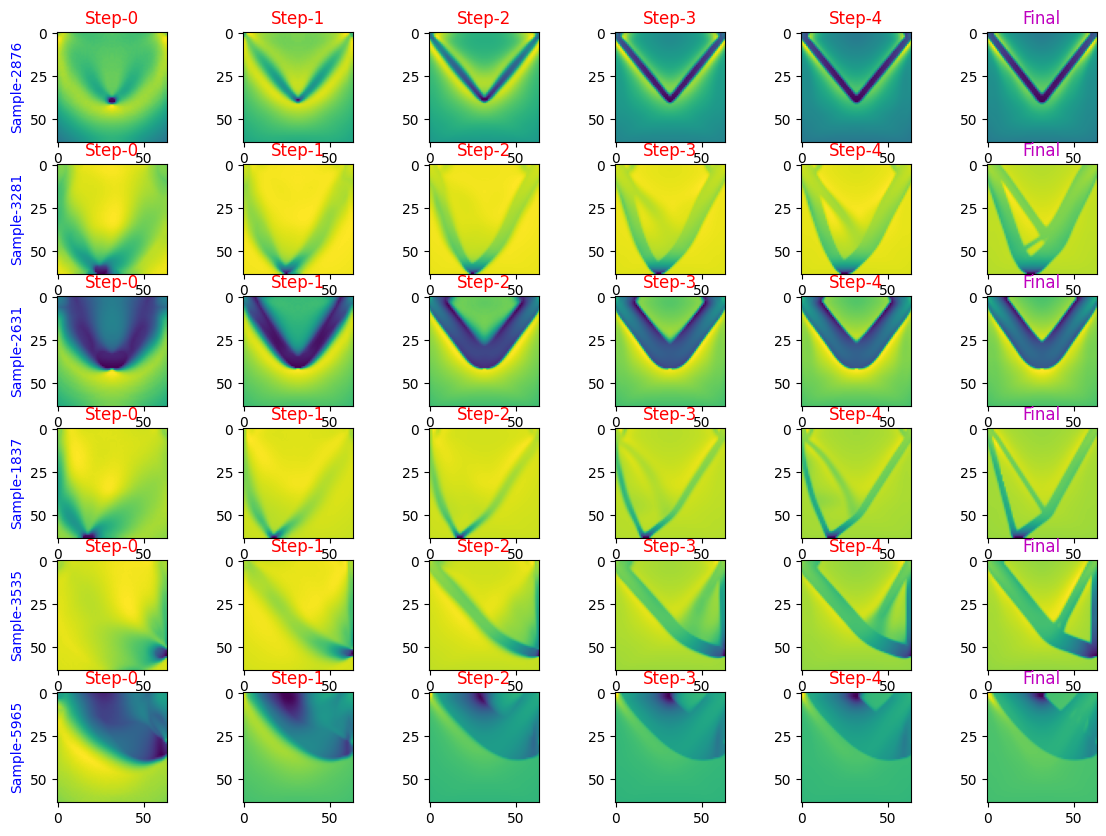

In [107]:
# from utilities3 import *
# import torch.nn as nn
# import torch.nn.functional as F
# import torch

ntrain = 8400
ntest = 168
sub = 1   # subsampling rate
batch_size =  20  #27
batch_size2 =  20  #27
t=data_in.shape[3]
h = 64
# data_in=reader.read_field('x_data')
# data_out=reader.read_field('y_data')

print(data_in.shape)
print(data_out.shape)

train_in =data_in[:ntrain,::sub,::sub]
train_out =data_out[:ntrain,::sub,::sub]


x_normalizer = UnitGaussianNormalizer(train_in)
x_normalizer.cpu()
train_in = x_normalizer.encode(train_in)
y_normalizer = UnitGaussianNormalizer(train_out)
y_normalizer.cpu()
train_out = y_normalizer.encode(train_out)

test_in=data_in[-ntest:,::sub,::sub]
# x_normalizer=UnitGaussianNormalizer(test_in)
test_out=data_out[-ntest:,::sub,::sub]

print(y_normalizer.mean.shape)
print(y_normalizer.std.shape)

test_in = x_normalizer.encode(test_in)

train_in = train_in.reshape(ntrain,h,h,t)
test_in = test_in.reshape(ntest,h,h,t)

fig1, ax = plt.subplots(nrows=6, ncols=t+1, figsize=(14,10), dpi=100)

indices = np.random.permutation( len(train_in) )[:6] 
for i in range( 6 ):
    for j in range( t+1):
        if j ==t :
            ax[i, j].imshow( train_out.cpu().to_dense()[indices[i] ,:, :] )
            ax[i, j].set_title('Final', color='m')
        else:
            ax[i, j].imshow( train_in.cpu().to_dense()[ indices[i],:,:,j] )
            ax[i, j].set_title('Step-{}'.format(j), color='red')
            if j == 0:
                ax[i, j].set_ylabel('Sample-{}'.format(indices[i]), color='blue')

train_out = train_out.reshape(ntrain,h,h)
test_out = test_out.reshape(ntest,h,h)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_in, train_out), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_in, test_out), batch_size=batch_size2, shuffle=False)


In [60]:
print(train_in.shape[0])
print(train_out.shape[0])

8400
8400


<KeysViewHDF5 ['sa_x', 'sa_y']>
torch.Size([1, 64, 64, 5])
torch.Size([1, 64, 64])


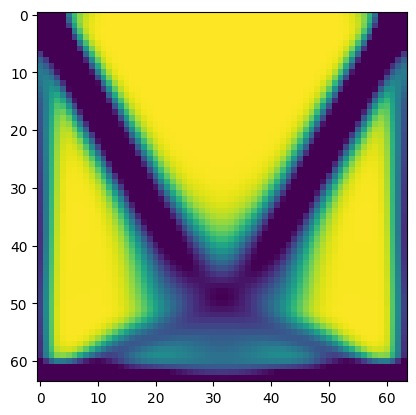

In [132]:
#for multi_load

reader3=MatReader("C:\\S.C. research\\WNO\\New folder\\mywork\\INN-TO\\DataSet\\sample_xy_MultiLoads.hdf5")
print(reader3.data.keys())

test_in_m=torch.permute(reader3.read_field('sa_y'),(3,0,1,2))[...,1::2]
test_out_m=torch.permute(reader3.read_field('sa_x'),(2,0,1))
print(test_in_m.shape)
print(test_out_m.shape)

# test_in_m=x_normalizer.encode(test_in_m)

plt.imshow(test_in_m.squeeze()[:,:,3])

In [9]:
# for non_linear_system(?)
reader4=MatReader("C:\\S.C. research\\WNO\\New folder\\mywork\\INN-TO\\DataSet\\sample_xy_nonlin1.hdf5")
print(reader4.data.keys())

test_in_n=torch.permute(reader4.read_field('sa_y'),(3,0,1,2))[...,0::3]
test_out_n=torch.permute(reader4.read_field('sa_x'),(2,0,1))
print(test_in_n.shape)
print(test_out_n.shape)
test_in_n=x_normalizer.encode(test_in_n)


<KeysViewHDF5 ['sa_x', 'sa_y']>
torch.Size([1, 64, 64, 5])
torch.Size([1, 64, 64])


In [30]:
# dynamic loading case

reader5=MatReader("C:\\S.C. research\\WNO\\New folder\\mywork\\INN-TO\\DataSet\\sample_xy_Dynamic.hdf5")
print(reader5.data.keys())

test_in_d=torch.permute(reader5.read_field('sa_y'),(3,0,1,2))[...,0::3]
test_out_d=torch.permute(reader5.read_field('sa_x'),(2,0,1))
print(test_in_d.shape)
print(test_out_d.shape)
test_in_d=x_normalizer.encode(test_in_d)

<KeysViewHDF5 ['sa_x', 'sa_y']>
torch.Size([1, 64, 64, 5])
torch.Size([1, 64, 64])


In [134]:
wavelet = ['near_sym_b', 'qshift_b']   # wavelet basis function  !!DON'T KNOW THIS BASIS FUNCTION
level = 4      # level of wavelet decomposition
width = 16# uplifting dimension  ! I have changed the width to 1/2 # 32
layers = 4       # no of wavelet layers

h = 64          # total grid size divided by the subsampling rate
grid_range = [1, 1]
in_channel = t+2 # 12  # input channel is 6: (4 for a(x,t1-t4), 2 for x)

In [135]:
# %%
""" The model definition """
model = WNO2d(width, level,layers=layers, size=[h,h], wavelet=wavelet,
              in_channel=in_channel, grid_range=grid_range,padding=0).to(device)
print(count_params(model))

335849


In [127]:
torch.cuda.empty_cache()

In [136]:
def save_checkpoints(epoch,model,optimizer,filename):
    checkpoints={
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch
    
    }
    torch.save(checkpoints, filename)
    

In [137]:
def load_checkpts(folder):
    chk_pts=[f for f in os.listdir(folder) if f.startswith("checkpoint_")]
    
    if not chk_pts:
        return None
    else:
        chk_pts.sort(key=lambda f: os.path.getmtime(f))
        chk_file=os.path.join(folder,chk_pts[-1])
        load_chk_pt=torch.load(chk_file)
        return load_chk_pt

In [138]:
""" Training and testing """

epochs = 150
learning_rate = 0.001
scheduler_step = 20
scheduler_gamma = 0.95

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)

train_loss = torch.zeros(epochs)
test_loss = torch.zeros(epochs)
myloss = LpLoss(size_average=False)
chk_pt_file=load_checkpts("C:\\S.C. research\\WNO\\New folder\\mywork")
if(chk_pt_file):
    model.load_state_dict(chk_pt_file['model_state_dict'])
    optimizer.load_state_dict(chk_pt_file['optimizer_state_dict'])
    start_epoch=chk_pt_file['epoch']+1
    
else: 
    start_epoch=0  
print(start_epoch)      

30


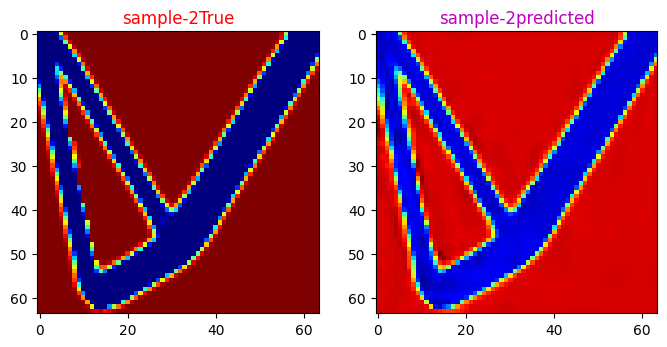

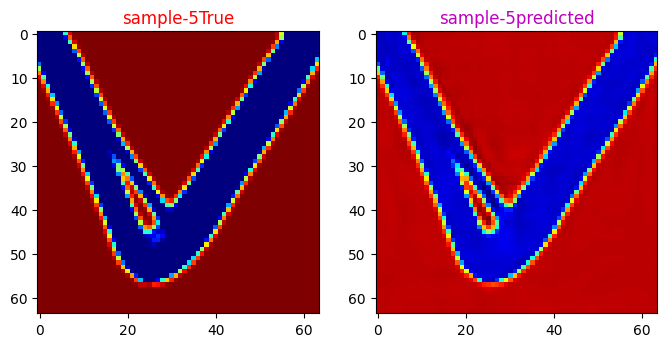

RuntimeError: shape '[20, 64, 64]' is invalid for input of size 32768

In [ ]:
batch_size=20

for ep in range(start_epoch,epochs):
    torch.cuda.empty_cache()
    c=0
    i=0
    model.train()
    t1 = default_timer()
    train_mse=0
    train_l2_step = 0
    train_l2_full = 0
    if (ep+1)%5==0:
        save_checkpoints(ep,model,optimizer,f'checkpoint_{(ep+1)}.pth')
    indices = [2,5,8]
    for xx, yy in train_loader:
        
        xx = xx.to(device)
        yy = yy.to(device)
        
        # for t in range(0, T):
            # y = yy[...] # t:t+step, retains the third dimension,
        y_normalizer.to(device)
        im = model(xx).to(device).reshape(batch_size,h,h)
        
        im = y_normalizer.decode(im)
        
        yy = y_normalizer.decode(yy)
        
        loss=myloss(im.reshape(batch_size,-1),yy.reshape(batch_size,-1))
        mse=F.mse_loss(im.reshape(batch_size,-1),yy.reshape(batch_size,-1))
        pred = im
            
        train_mse+=mse.item()
        train_l2_full += loss.item()  # Monitor the loss function,, Something wrong with it..
        

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    test_l2_step = 0
    test_l2_full = 0
    with torch.no_grad():
        
        
        for xx, yy in test_loader:
            
            loss = 0
            xx = xx.to(device)
            yy = yy.to(device)
            # print(xx.shape)
            im = model(xx).reshape(batch_size,h,h).to(device)
            im = y_normalizer.decode(im)

            loss=myloss(im.reshape(batch_size,-1),yy.reshape(batch_size,-1))
            pred = im
                 
            test_l2_full += loss.item()
            # plt.subplot(2,5,c+1)
            if(ep%15==0 and c in indices):
                
                fig1, ax = plt.subplots( nrows=1,ncols=2,figsize=(8,5) ,dpi=100)
                
                ax[0].imshow( yy.cpu()[c,:,:],label='True',cmap='jet')
                ax[0].set_title('sample-{}'.format(c)+'True',color='r')
                ax[1].imshow(pred.cpu()[c,:,:],label='predicted',cmap='jet')
                ax[1].set_title('sample-{}'.format(c)+'predicted',color='m')
                if(c==5):
                    plt.savefig(f"it-{ep} load loc.png")
                plt.show()
            c+=1

    train_loss[ep] = train_l2_full/train_in.shape[0]
    test_loss[ep] = test_l2_full/test_in.shape[0]
    # test_loss[ep]=loss.item()
    train_mse /= len(train_loader)
    
    t2 = default_timer() 
    scheduler.step()
    print(ep, t2 - t1,train_mse, train_loss[ep], test_loss[ep] )
   
torch.save(model,'load_loc_14710.pt')


In [20]:
print(test_in.shape, test_out.shape)

torch.Size([168, 64, 64, 5]) torch.Size([168, 64, 64])


0 0.1008015125989914
1 0.07149480283260345
2 0.03849796950817108
3 0.024057410657405853
4 0.09149617701768875
5 0.04649695008993149
6 0.11712078005075455
7 0.027351288124918938
8 0.016645552590489388
9 0.07350818812847137
10 0.026592401787638664
11 0.03657617047429085
12 0.04444568604230881
13 0.03334713354706764
14 0.07416435331106186
15 0.03063889779150486
16 0.02334059402346611
17 0.07057899236679077
18 0.058343905955553055
19 0.05596563592553139
20 0.10371304303407669
21 0.02882491424679756
22 0.029807420447468758
23 0.02935009077191353
24 0.0412079356610775
25 0.01653349958360195
26 0.013463848270475864
27 0.05751722678542137
28 0.025888880714774132
29 0.0773165225982666
30 0.05121811479330063
31 0.0393192358314991
32 0.032283928245306015
33 0.029276838526129723
34 0.026244303211569786
35 0.021509982645511627
36 0.04291597008705139
37 0.04566623270511627
38 0.041866619139909744
39 0.014451165683567524
40 0.01579485833644867
41 0.14805492758750916
42 0.09336624294519424
43 0.027886

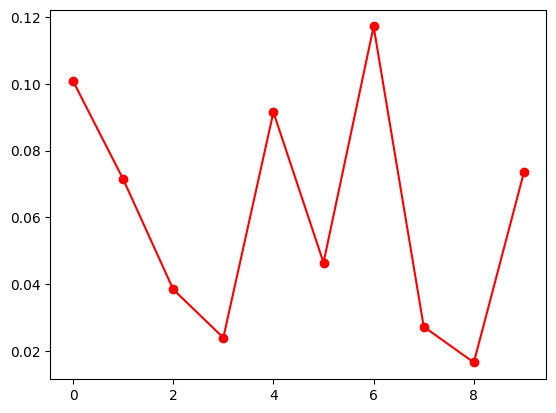

In [ ]:
# %%
""" Prediction """
pred0 = torch.zeros(test_out.shape)
index = 0
test_e =np.zeros(test_out.shape[0])
batch_size=1        
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_in, test_out), batch_size, shuffle=False)
y_normalizer.cuda()
# model=torch.load('C:\\S.C. research\\WNO\\New folder\\mywork\\MyModel_4.pt')
with torch.no_grad():
    for xx, yy in test_loader:
        test_l2_step = 0
        test_l2_full = 0
        loss = 0
        xx = xx.to(device)
        yy = yy.to(device)

        im = model(xx).reshape(batch_size,h,h).to(device)
        im = y_normalizer.decode(im)
        
        loss+=myloss(im.reshape(batch_size,-1),yy.reshape(batch_size,-1))
             
        pred0[index] = im
        test_e[index] = loss.item()
        
        print(index, loss.item())
        index = index + 1
index=[i for i in range(10)]        
# test_err=test_e.numpy()[:10]

plt.plot(index,test_e[:10],'ro-')
plt.show()


In [26]:
print(np.mean(test_e))

0.044418444529929685


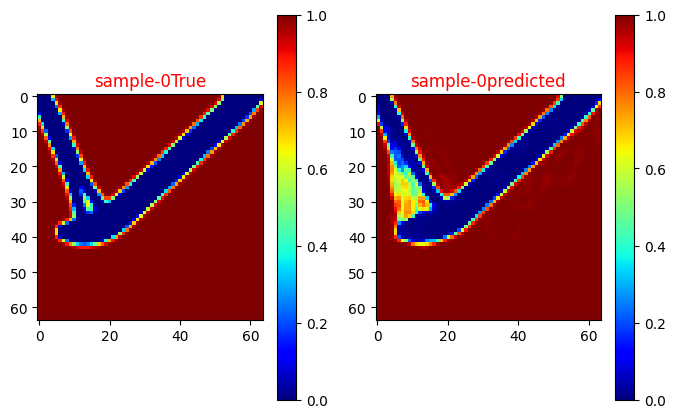

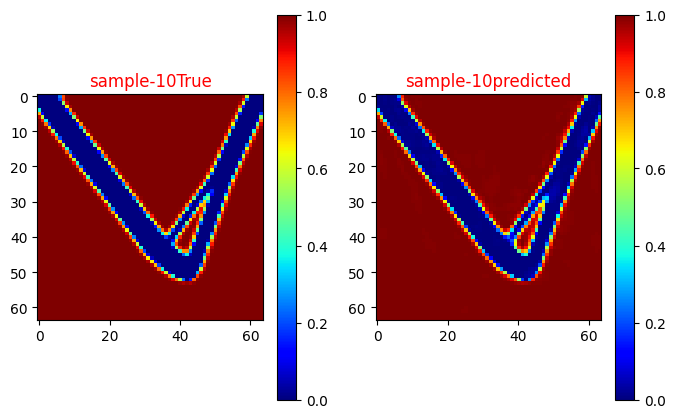

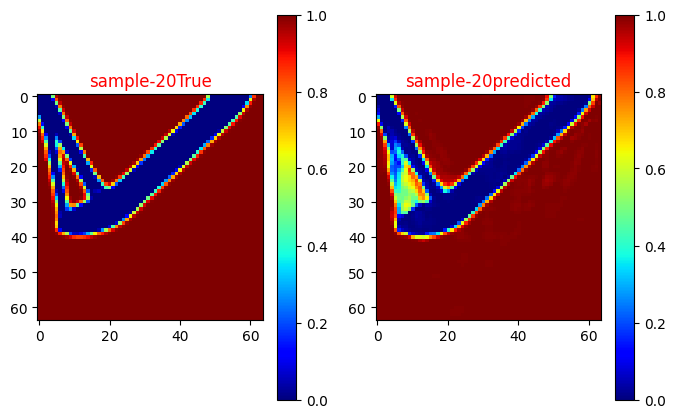

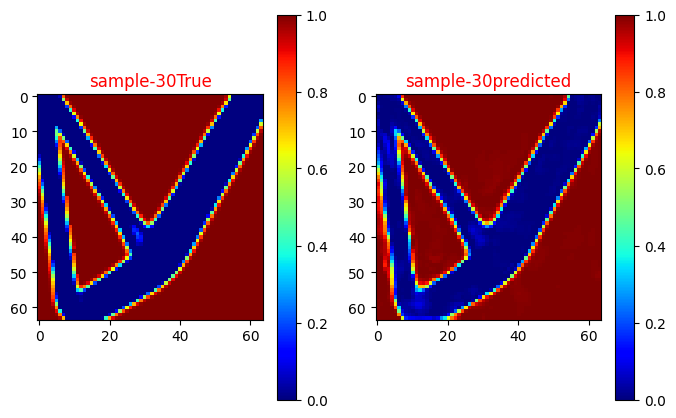

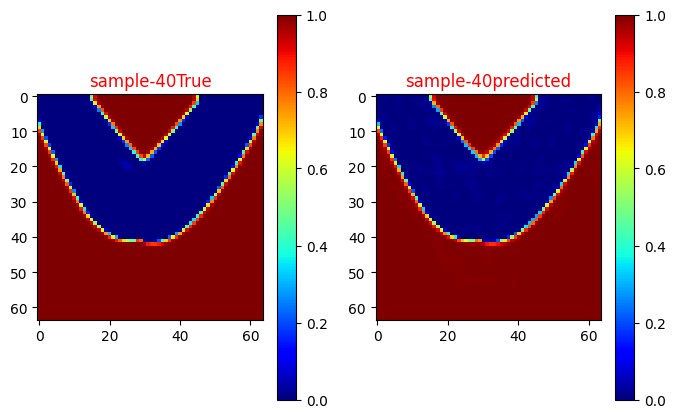

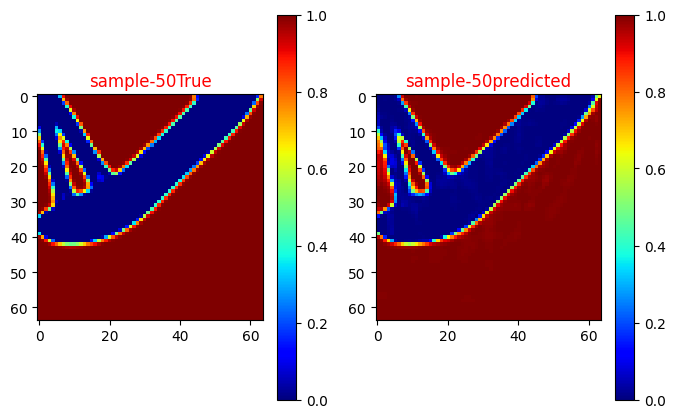

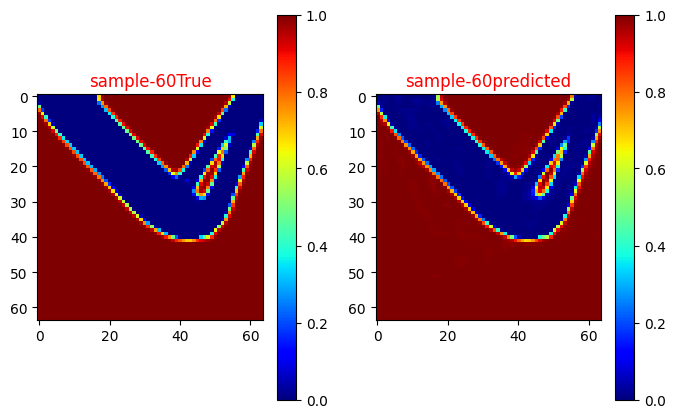

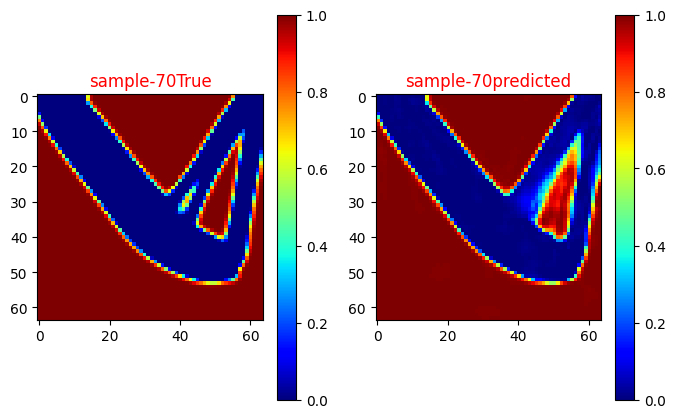

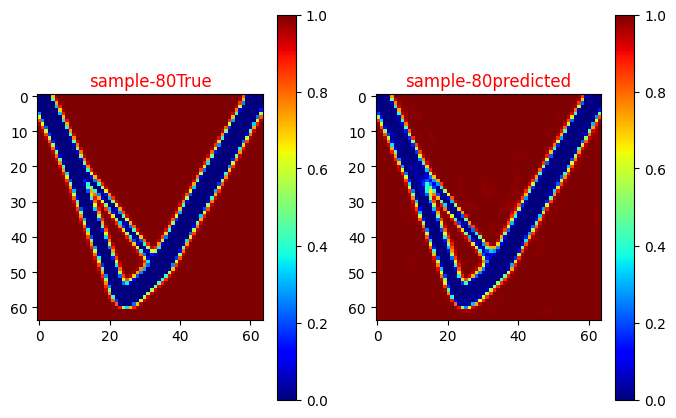

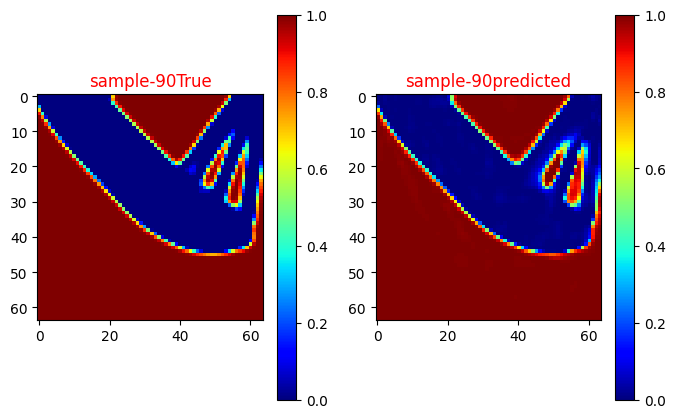

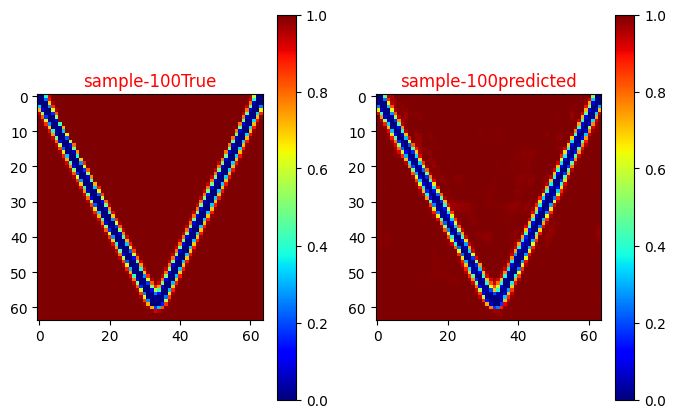

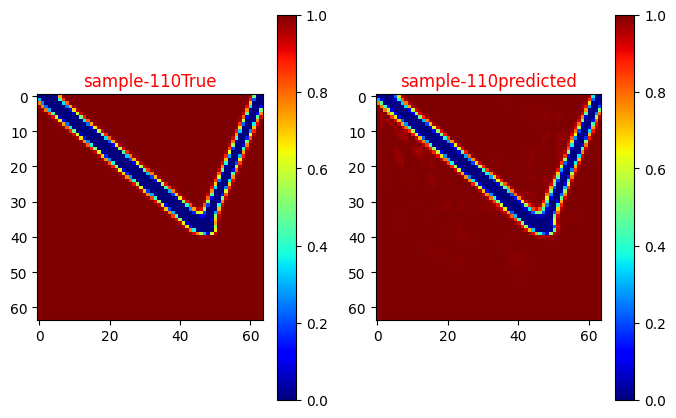

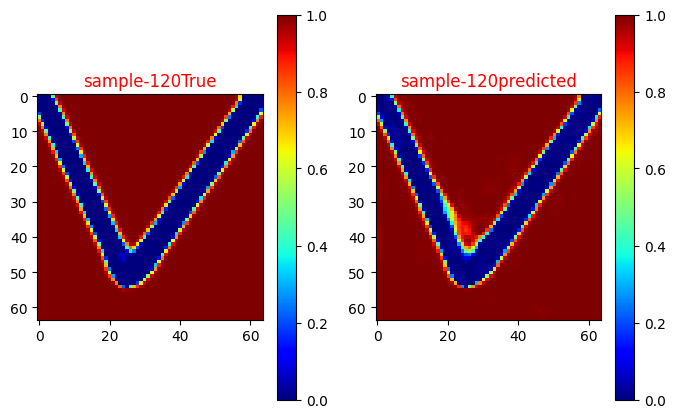

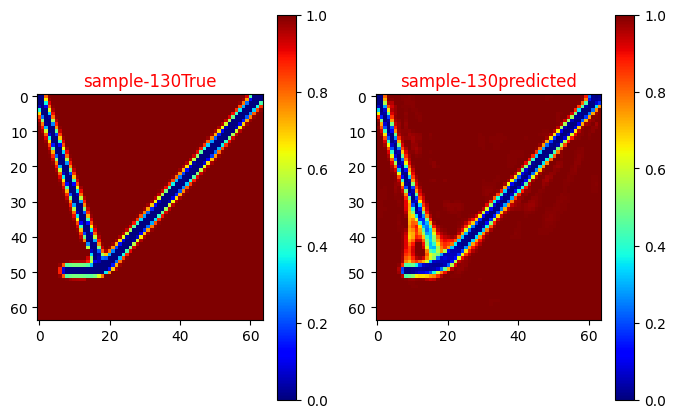

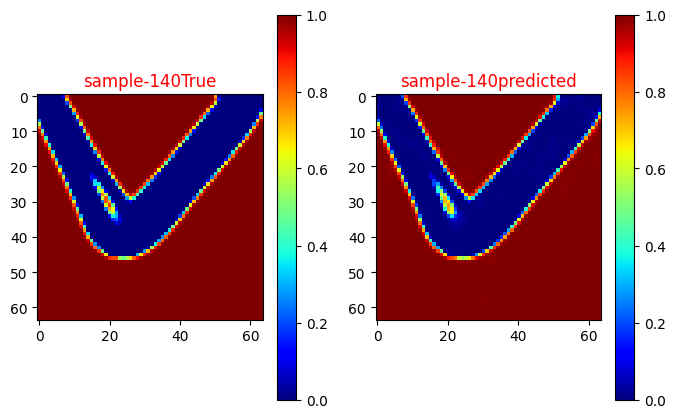

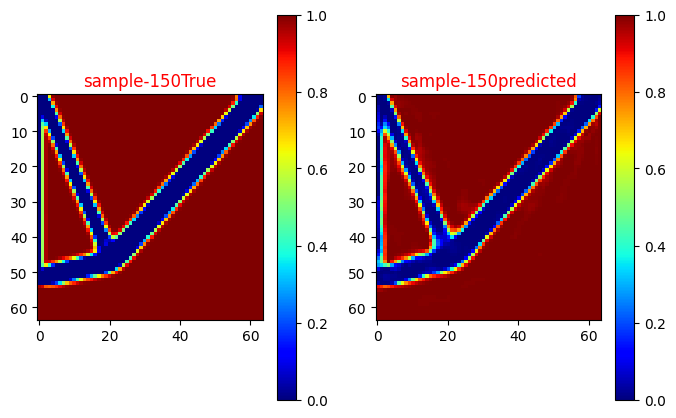

In [27]:
# plt.subplot(2,5,c+1)

for i in range(16):   
    fig1, ax = plt.subplots( nrows=1,ncols=2,figsize=(8,5) ,dpi=100)

    im0 = ax[0].imshow( test_out.cpu()[i*10,:,:],label='True',cmap='jet',vmin=0,vmax=1)
    plt.colorbar(im0, ax=ax[0])
    ax[0].set_title('sample-{}'.format(i*10)+'True',color='r')
    
    im1 = ax[1].imshow(pred0.cpu()[i*10,:,:],label='predicted',cmap='jet',vmin=0,vmax=1) # custom cmap with filter
    
    plt.colorbar(im1, ax=ax[1])
    ax[1].set_title('sample-{}'.format(i*10)+'predicted',color='r')
    if(i%4==0):
        filename = f"test_plot_{i*10} with load loc odd 30.png"
        # plt.savefig(filename)
    plt.show()
    

0.5880082845687866
torch.Size([64, 64])
torch.Size([64, 64])
----------------------------------------------------------------------------------------------------------------------------------------
tensor([[-0.0097, -0.0057, -0.0260,  ...,  0.9994,  1.0012,  1.0015],
        [ 0.0064,  0.0148, -0.0014,  ...,  0.9988,  0.9996,  1.0000],
        [ 0.0492,  0.0493,  0.0406,  ...,  0.9971,  0.9986,  0.9993],
        ...,
        [ 0.0483,  0.0454,  0.0446,  ...,  0.9823,  0.9791,  0.9832],
        [ 0.0378,  0.0499,  0.0559,  ...,  0.9830,  0.9812,  0.9850],
        [ 0.0464,  0.0568,  0.0735,  ...,  0.9876,  0.9856,  0.9886]],
       device='cuda:0')


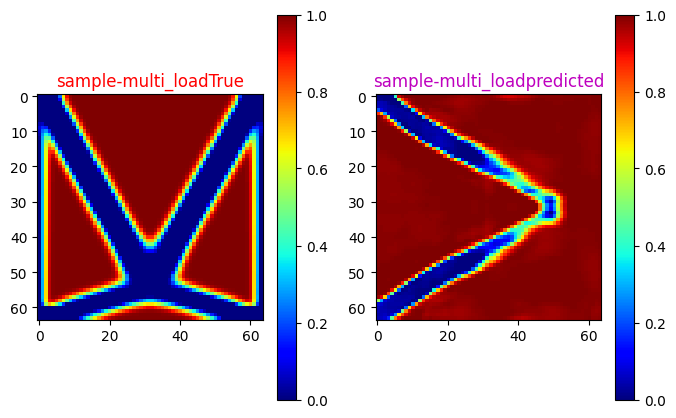

In [139]:
xx_m=test_in_m.to(device)
yy_m=test_out_m.to(device)
y_normalizer.cuda()
pred=torch.zeros(yy_m.shape)
# model=torch.load('C:\\S.C. research\\WNO\\New folder\\mywork\\MyModel_load_loc.pt')
file=open("nl_multi_og.txt","w")
with torch.no_grad():
    im = model(xx_m).reshape(1,h,h).to(device)
    
    pred = y_normalizer.decode(im)
    
    loss=myloss(pred.reshape(1,-1).to(device),test_out_m.reshape(1,-1).to(device))
    print(loss.item())
    pred=pred.squeeze(0)
    
    print(pred.shape)
    pred_T=torch.transpose(pred,0,1)
    
    print(pred_T.shape)
    print("----------------------------------------------------------------------------------------------------------------------------------------")
    print(pred_T)
    for i in range(64):
        for j in range(64):
                file.write(str(pred.cpu()[i,j])[7:-1]+" ")
    sio.savemat("predicted multi_load.mat",{'predicted_tensor':pred.cpu()})

    fig1, ax = plt.subplots( nrows=1,ncols=2,figsize=(8,5) ,dpi=100)

    im0 = ax[0].imshow( test_out_m.cpu().squeeze(),label='True',cmap='jet',vmin=0,vmax=1)
    plt.colorbar(im0, ax=ax[0])
    ax[0].set_title('sample-multi_load'+'True',color='r')
        
    im1 = ax[1].imshow(pred_T.cpu().squeeze(),label='predicted',cmap='jet',vmin=0,vmax=1) 
        
    plt.colorbar(im1, ax=ax[1])
    ax[1].set_title('sample-multi_load'+'predicted',color='m')
    plt.savefig('multi_load_case odd 30')
    plt.show()
file.close()

0.5126953125
torch.Size([64, 64])
torch.Size([64, 64])
----------------------------------------------------------------------------------------------------------------------------------------
tensor([[-9.6851e-02, -6.3874e-02, -4.9813e-02, -2.3895e-02,  8.3111e-03,
          3.6831e-02,  4.2815e-02,  2.4571e-02,  1.9256e-02,  2.0238e-02,
          1.8849e-02,  1.7401e-02,  4.1899e-02,  8.0451e-02,  1.0998e-01,
          1.3169e-01,  1.4986e-01,  1.6995e-01,  1.8009e-01,  1.9522e-01,
          2.2695e-01,  2.5931e-01,  3.0762e-01,  4.0278e-01,  5.6132e-01,
          6.7540e-01,  7.9667e-01,  9.1391e-01,  9.9143e-01,  1.0174e+00,
          1.0238e+00,  1.0260e+00,  1.0248e+00,  1.0226e+00,  1.0213e+00,
          1.0230e+00,  1.0240e+00,  1.0212e+00,  1.0349e+00,  1.0408e+00,
          1.0097e+00,  9.9123e-01,  9.6514e-01,  9.4528e-01,  9.2228e-01,
          9.1194e-01,  9.1450e-01,  9.4476e-01,  9.8350e-01,  1.0134e+00,
          1.0566e+00,  1.0790e+00,  1.0785e+00,  1.0461e+00,  1.0204

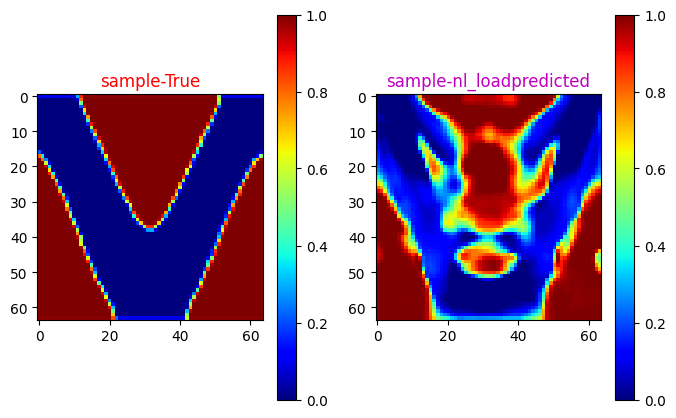

In [22]:
xx_n=test_in_n.to(device)
yy_n=test_out_n.to(device)
y_normalizer.cuda()
pred=torch.zeros(yy_n.shape)
# file=open("nl_tensor.script","w")
#model=torch.load('C:\\S.C. research\\WNO\\New folder\\mywork\\MyModel_load_loc.pt')
file=open("nl_non_T.txt","w")
torch.set_printoptions(threshold=10000)
with torch.no_grad():
    im = model(xx_n).reshape(1,h,h).to(device)
    pred = y_normalizer.decode(im)
    
    #to find the volume fraction
    solid_pixels = torch.sum(test_out_n<0.7)
    # print(solid_pixels)
    total_pixels = torch.prod(torch.tensor(test_out_n.shape))  # Total number of elements
    print(float(solid_pixels / total_pixels))
    
    loss=myloss(pred.reshape(1,-1).to(device),test_out_n.reshape(1,-1).to(device))
    # print(loss.item())
    # plt.imshow(pred.cpu().squeeze())
    # plt.savefig('input_nl_30_odd')
    # plt.show()
   
    pred=pred.squeeze(0)
    sio.savemat("predicted non linear.mat",{'predicted_tensor':pred.cpu()})
    print(pred.shape)
    pred_T=torch.transpose(pred,0,1)
    
    print(pred_T.shape)
    print("----------------------------------------------------------------------------------------------------------------------------------------")
    print(pred_T)
    for i in range(64):
        for j in range(64):
            file.write(str(pred_T.cpu()[i,j])[7:-1]+" ")
        
    
    fig1, ax = plt.subplots( nrows=1,ncols=2,figsize=(8,5) ,dpi=100)

    im0 = ax[0].imshow( test_out_n.cpu().squeeze(),label='True',cmap='jet',vmin=0,vmax=1)
    plt.colorbar(im0, ax=ax[0])
    ax[0].set_title('sample-'+'True',color='r')
        
    im1 = ax[1].imshow(pred.cpu().squeeze(),label='predicted',cmap='jet',vmin=0,vmax=1) # custom cmap with filter
        
    plt.colorbar(im1, ax=ax[1])
    ax[1].set_title('sample-nl_load'+'predicted',color='m')
    plt.savefig('nonlinear_system odd 30')
    plt.show()
file.close()


0.3539023697376251


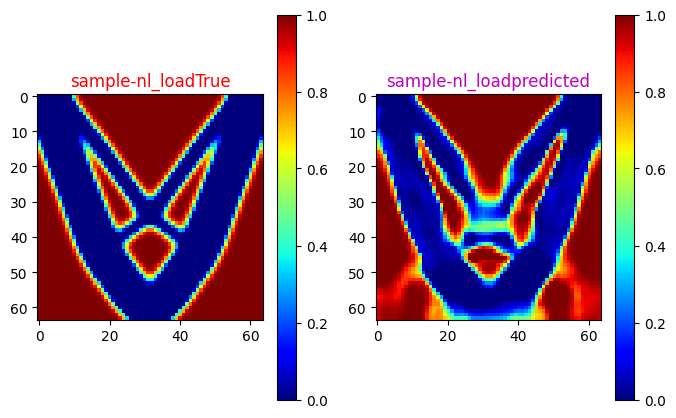

In [33]:
xx_d=test_in_d.to(device)
yy_d=test_out_d.to(device)
y_normalizer.cuda()
pred=torch.zeros(yy_d.shape)
with torch.no_grad():
    im = model(xx_d).reshape(1,h,h).to(device)
    
    pred = y_normalizer.decode(im)
    loss=myloss(pred.reshape(1,-1).to(device),test_out_d.reshape(1,-1).to(device))
    print(loss.item())

    fig1, ax = plt.subplots( nrows=1,ncols=2,figsize=(8,5) ,dpi=100)

    im0 = ax[0].imshow( test_out_d.cpu().squeeze(),label='True',cmap='jet',vmin=0,vmax=1)
    plt.colorbar(im0, ax=ax[0])
    ax[0].set_title('sample-nl_load'+'True',color='r')
        
    im1 = ax[1].imshow(pred.cpu().squeeze(),label='predicted',cmap='jet',vmin=0,vmax=1) # custom cmap with filter
        
    plt.colorbar(im1, ax=ax[1])
    ax[1].set_title('sample-nl_load'+'predicted',color='m')
    # plt.savefig('dynamic_load_case 30')
    plt.show()